This is replication of Prof. Miyamoto lecture on local projection. https://www.youtube.com/watch?v=43KLVIcOTwk

The code to Stata do file is available at [Link to Stata do file](https://github.com/htdanil/referenced_to_github/blob/master/G0006%20lpm.do)

---

In [1]:
%%capture
import rpy2.rinterface
from IPython.display import Image
%load_ext rpy2.ipython
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

In [2]:
%%capture
%%R
library(plm)
library(lmtest)
library(glue)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#---------------------------- STATA CODE ---------------------------------------------------------
# use "https://github.com/htdanil/referenced_to_github/raw/master/G0005%20multipliers_ex.dta", clear
#-------------------------------------------------------------------------------------------------
df = pd.read_stata('https://github.com/htdanil/referenced_to_github/raw/master/G0005%20multipliers_ex.dta')
df.head()

,sbbq_phase,ifscode,iso3code,year,cgv,gdpv,country,lur,st_policy_rate_ea,trend,time,cpv,emp,itv,shock
0,0,122,AUT,2014,6.168748e+10,3.089073e+11,Austria,5.616667,0.158333,30.0,99.0,1.804910e+11,4112675.0,7.642188e+10,0.174396
1,0,122,AUT,2006,5.619108e+10,2.874214e+11,Austria,5.225000,2.791667,22.0,91.0,1.702440e+11,3826000.0,7.289692e+10,-0.039317
2,1,122,AUT,2009,6.059147e+10,2.905582e+11,Austria,5.325000,1.229167,25.0,94.0,1.748620e+11,3982200.0,7.199644e+10,-0.392512
3,0,122,AUT,2017,6.420116e+10,3.273375e+11,Austria,5.525000,0.000000,33.0,102.0,1.871970e+11,4260425.0,8.445651e+10,0.094709
4,0,122,AUT,2008,5.912896e+10,3.010510e+11,Austria,4.100000,3.854167,24.0,93.0,1.732910e+11,3994100.0,7.757599e+10,0.194231


In [5]:
%Rpush df
# %R saveRDS(df,'temp/rds')

In [6]:
%%R
#---------------------------- STATA CODE ---------------------------------------------------------
# tsset ifscode year, yearly
#-------------------------------------------------------------------------------------------------

# put time variable at the end of the index which makes it possible to take lag, difference of time series
df <- plm::pdata.frame(df, index = c('ifscode','year'), drop.index = F, row.names = T)
head(index(df))

   ifscode year
33     122 1985
12     122 1986
30     122 1987
18     122 1988
28     122 1989
9      122 1990


In [7]:
%%R
#---------------------------- STATA CODE ---------------------------------------------------------
# gen lny = ln(gdpv)
# gen f1 = 100*(lny-l.lny)
# gen f2 = 100*(f.lny-l.lny)
# gen f3 = 100*(f2.lny-l.lny)
# gen f4 = 100*(f3.lny-l.lny)
# gen f5 = 100*(f4.lny-l.lny)

# gen gry = 100*(lny-l.lny)
# gen trend2=trend^2
#-------------------------------------------------------------------------------------------------

df$lny <- log(df$gdpv)

horizon = 5

for (i in seq(1,5,1)){
    ii <- 1-i
    eval(parse(text = glue('df$f{i} <- 100*(lag(df$lny,{ii}) - lag(df$lny))')))
}

df$gry <- df$f1
df$trend2 <- df$trend^2

head(df[c('lny','f1','f2','f3','f4','f5','gry','trend2')])

              lny       f1       f2        f3       f4       f5      gry trend2
122-1985 25.85231       NA       NA        NA       NA       NA       NA      1
122-1986 25.87506 2.275310 3.623351  6.866082 10.67951 14.93338 2.275310      4
122-1987 25.88854 1.348041 4.590772  8.404202 12.65807 16.04180 1.348041      9
122-1988 25.92097 3.242731 7.056161 11.310029 14.69376 16.76567 3.242731     16
122-1989 25.95910 3.813430 8.067298 11.451026 13.52294 14.04836 3.813430     25
122-1990 26.00164 4.253868 7.637596  9.709508 10.23493 12.60866 4.253868     36


## estimating fixed effect regression using panel data with robust standard error (example)

---

In [8]:
%%R
mod_plm <- plm(f1 ~ shock + factor(year), data = df, model = 'within') #choose model = 'within' for fixed effect
#-----------------------------------------------------------------------------------------
# The equivalent OLS syntax is
#
# lm(f1 ~ shock + factor(year) + factor(ifscode), data = df)
#
# This provides exactly same coefficient estimates and standard error.
#-----------------------------------------------------------------------------------------

summary(mod_plm)

Oneway (individual) effect Within Model

Call:
plm(formula = f1 ~ shock + factor(year), data = df, model = "within")

Unbalanced Panel: n = 17, T = 17-32, N = 503

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-9.453055 -0.906740 -0.076151  0.874500 15.752459 

Coefficients:
                  Estimate Std. Error t-value  Pr(>|t|)    
shock             1.246448   0.271790  4.5861 5.849e-06 ***
factor(year)1988  1.123054   0.732520  1.5331 0.1259387    
factor(year)1989  1.327292   0.732720  1.8115 0.0707307 .  
factor(year)1990  0.254062   0.732964  0.3466 0.7290348    
factor(year)1991 -1.527237   0.722032 -2.1152 0.0349576 *  
factor(year)1992 -1.399037   0.720152 -1.9427 0.0526705 .  
factor(year)1993 -1.581861   0.724418 -2.1836 0.0295007 *  
factor(year)1994  1.150449   0.720557  1.5966 0.1110483    
factor(year)1995  1.219935   0.720892  1.6923 0.0912827 .  
factor(year)1996  0.588614   0.720282  0.8172 0.4142426    
factor(year)1997  1.297342   0.709656  1.8281 0.

In [9]:
%%R
#--------------------------------------------------------------------------------------
# Since stata uses a specific small-sample correction (sss) to calculate robust SE, 
# we are re-testing coefficient using sss in R in order to obtain robust SE like stata.
#--------------------------------------------------------------------------------------
coef<-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss'))
coef


t test of coefficients:

                  Estimate Std. Error t value  Pr(>|t|)    
shock             1.246448   0.369225  3.3758 0.0007991 ***
factor(year)1988  1.123054   0.597443  1.8798 0.0607798 .  
factor(year)1989  1.327292   0.638990  2.0772 0.0383474 *  
factor(year)1990  0.254062   0.837167  0.3035 0.7616641    
factor(year)1991 -1.527237   1.030511 -1.4820 0.1390290    
factor(year)1992 -1.399037   0.833413 -1.6787 0.0939015 .  
factor(year)1993 -1.581861   1.113684 -1.4204 0.1561817    
factor(year)1994  1.150449   1.090108  1.0554 0.2918251    
factor(year)1995  1.219935   0.866759  1.4075 0.1599731    
factor(year)1996  0.588614   0.864132  0.6812 0.4961159    
factor(year)1997  1.297342   0.746836  1.7371 0.0830446 .  
factor(year)1998  0.080284   0.948646  0.0846 0.9325924    
factor(year)1999  1.393659   0.829638  1.6798 0.0936763 .  
factor(year)2000  2.254706   0.827611  2.7244 0.0066914 ** 
factor(year)2001 -0.131681   0.726226 -0.1813 0.8561951    
factor(year)20

## Resuming replication of the stata code
---

In [10]:
%%R
#---------------------------- STATA CODE ---------------------------------------------------------
# *-------------------------------------------------------------------------------
# *                              Linear Model  
# *-------------------------------------------------------------------------------
# foreach X in f {
# 	gen b_`X'=.
# 	gen se_`X'=.
	
# 	forvalues y = 1/5 {
			
# 			areg `X'`y' shock i.year,  cluster(ifscode) absorb(ifscode)			
			
# 			replace b_`X' = e(N) if _n==20+`y'
# 			replace se_`X' = e(N_clust) if _n==20+`y'
			
# 			replace b_`X' =  _b[shock] if _n==`y'+1
# 			replace se_`X' = _se[shock] if _n==`y'+1
# 			}
# 	}
#-------------------------------------------------------------------------------------------------


#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
b_f <- NULL
se_f <- NULL

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(1,5,1)){
    eval(parse(text = (glue("mod_plm <- plm(f{i} ~ shock + factor(year), data = df, model = 'within')")))) #choose within for fixed effect
    coef <-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss'))
    
    b_f <- c(b_f, coef['shock','Estimate'] )
    se_f <- c(se_f, coef['shock','Std. Error'])
}

In [11]:
%%R
#---------------------------- STATA CODE ---------------------------------------------------------
# *-------------------------------------------------------------------------------
# *                      State dependent Fiscal Multipliers  
# *-------------------------------------------------------------------------------

# summarize gry if shock!=. 
# gen f1mn = r(mean)
# gen f1se = r(sd)

# gen zslack = (gry- f1mn)/ f1se
# gen g_slack = exp(-1.5*zslack)/(1+exp(-1.5*zslack))

# gen fl_slack_shock  = shock*(1-g_slack) /*boom*/
# gen fh_slack_shock  = shock*(g_slack)   /*recession*/


# *Endogenous variables: f de p pv u tm emp

# foreach X in f{	
# 	foreach z in slack {
# 	gen bfh_`z'=.
# 	gen sefh_`z'=.
# 	gen bfl_`z' = .
# 	gen sefl_`z'=.
	
# 	forvalues y = 1/5 {
# 	areg `X'`y'  fh_`z'_shock fl_`z'_shock i.year , absorb(ifscode) cluster(ifscode) 
	
# 	replace bfh_`z'  = _b[fh_`z'] if _n==`y'+1
# 	replace sefh_`z' = _se[fh_`z'] if _n==`y'+1
# 	replace bfl_`z'  = _b[fl_`z'] if _n==`y'+1
# 	replace sefl_`z' = _se[fl_`z'] if _n==`y'+1
# 	replace bfh_`z'  = e(N) if _n==10+`y'
# 	replace sefh_`z' = e(N_clust) if _n==10+`y'
# 	}
# }
# }
#-------------------------------------------------------------------------------------------------

f1mn <- mean(df$gry[df$shock != 'NaN'], na.rm = TRUE)
f1se <- sd(df$gry[df$shock != 'NaN'], na.rm = TRUE)

df$zslack <- (df$gry - f1mn)/f1se
df$g_slack <- exp(-1.5*df$zslack)/(1+exp(-1.5*df$zslack))

df$fl_slack_shock <- df$shock*(1-df$g_slack) #boom
df$fh_slack_shock <- df$shock*df$g_slack #recession

#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
bfh_slack <- NULL
sefh_slack <- NULL

bfl_slack <- NULL
sefl_slack <- NULL

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(1,5,1)){
    eval(parse(text = (glue("mod_plm <- plm(f{i} ~ fh_slack_shock + fl_slack_shock + factor(year), data = df, model = 'within')")))) #choose within for fixed effect
    coef <-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss'))
    
    bfh_slack <- c(bfh_slack, coef['fh_slack_shock','Estimate'])
    sefh_slack <- c(sefh_slack, coef['fh_slack_shock','Std. Error'])
    
    bfl_slack <- c(bfl_slack, coef['fl_slack_shock','Estimate'])
    sefl_slack <- c(sefl_slack, coef['fl_slack_shock','Std. Error'])
}

In [12]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
b_f         = %Rget b_f
se_f        = %Rget se_f

bfh_slack   = %Rget bfh_slack
sefh_slack  = %Rget sefh_slack

bfl_slack   = %Rget bfl_slack
sefl_slack  = %Rget sefl_slack

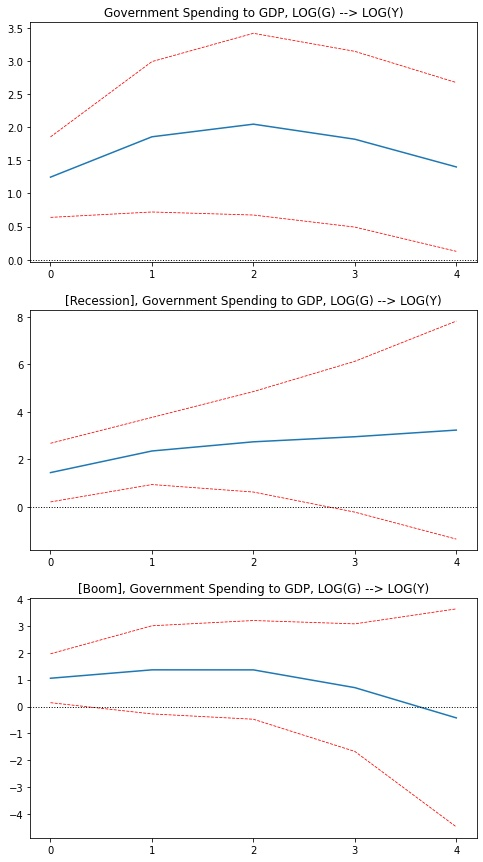

In [13]:

#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------

fig = plt.figure(figsize=(8,15))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

horizon = 5

ax1.plot(b_f[:horizon])
ax1.plot((b_f + 1.645 * se_f)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.plot((b_f - 1.645 * se_f)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.set_title('Government Spending to GDP, LOG(G) --> LOG(Y)')
ax1.set_xticks(range(5))

ax2.plot(bfh_slack[:horizon])
ax2.plot((bfh_slack + 1.645 * sefh_slack)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.plot((bfh_slack - 1.645 * sefh_slack)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.axhline(0, color='black', linestyle=':', linewidth=1)
ax2.set_title('[Recession], Government Spending to GDP, LOG(G) --> LOG(Y)')
ax2.set_xticks(range(5))

ax3.plot(bfl_slack[:horizon])
ax3.plot((bfl_slack + 1.645 * sefl_slack)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.plot((bfl_slack - 1.645 * sefl_slack)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.axhline(0, color='black', linestyle=':', linewidth=1)
ax3.set_title('[Boom], Government Spending to GDP, LOG(G) --> LOG(Y)')
ax3.set_xticks(range(5))